In [3]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

dataset_path = "/content/drive/MyDrive/animal_dataset/animal_dataset"
categories = [c for c in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, c))]
print("Categories found:", categories)


Categories found: ['panda', 'dog', 'cat']


In [5]:
IMG_SIZE = 32
processed_data = []

for label, cat in enumerate(categories):
    folder = os.path.join(dataset_path, cat)

    for img_name in tqdm(os.listdir(folder), desc=f"Loading {cat}"):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)

        if img is None:
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
        processed_data.append([resized.flatten(), label])

print("Total images loaded:", len(processed_data))

Loading cat: 100%|██████████| 100/100 [00:01<00:00, 63.00it/s]

Total images loaded: 300


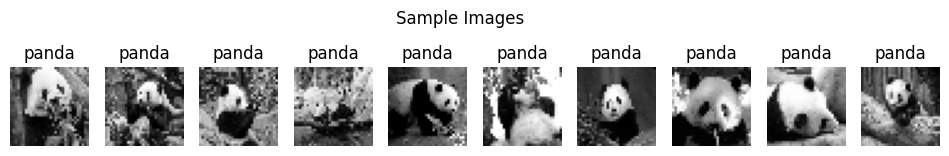

In [6]:
plt.figure(figsize=(12, 2))
for i in range(min(10, len(processed_data))):
    img, lab = processed_data[i]
    plt.subplot(1, 10, i+1)
    plt.imshow(img.reshape(32, 32), cmap='gray')
    plt.title(categories[lab])
    plt.axis('off')
plt.suptitle("Sample Images")
plt.show()

In [7]:
random.seed(42)
random.shuffle(processed_data)

In [8]:
fold_size = len(processed_data) // 5
folds = [
    processed_data[0:fold_size],
    processed_data[fold_size:fold_size*2],
    processed_data[fold_size*2:fold_size*3],
    processed_data[fold_size*3:fold_size*4],
    processed_data[fold_size*4:]
]
print("Fold sizes:", [len(f) for f in folds])


Fold sizes: [60, 60, 60, 60, 60]


In [9]:
def calc_l2_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

def calc_l1_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))


In [10]:
def knn_predict(X_train, y_train, x_test, k=3, metric='L2'):
    distances = []

    for i in range(len(X_train)):
        if metric == 'L1':
            dist = calc_l1_distance(X_train[i], x_test)
        else:
            dist = calc_l2_distance(X_train[i], x_test)

        distances.append((dist, y_train[i]))

    distances.sort(key=lambda x: x[0])
    top_k = [label for _, label in distances[:k]]

    vote = {}
    for l in top_k:
        vote[l] = vote.get(l, 0) + 1

    return max(vote, key=vote.get)


In [11]:
K_values = list(range(1, 11))
metrics = ['L2', 'L1']

cv_results = {m: [[] for _ in range(5)] for m in metrics}

for metric in metrics:
    print(f"\n===== Using {metric} Distance =====")

    for fold_idx in range(5):

        val = folds[fold_idx]
        train = [item for i, f in enumerate(folds) if i != fold_idx for item in f]

        X_train = np.array([img for img, lab in train])
        y_train = np.array([lab for img, lab in train])
        X_val = np.array([img for img, lab in val])
        y_val = np.array([lab for img, lab in val])

        print(f"\nFold {fold_idx + 1}")

        for k in K_values:
            correct = 0
            for i in range(len(X_val)):
                pred = knn_predict(X_train, y_train, X_val[i], k=k, metric=metric)
                if pred == y_val[i]:
                    correct += 1

            acc = (correct / len(X_val)) * 100
            cv_results[metric][fold_idx].append(acc)
            print(f"K = {k}: Accuracy = {acc:.2f}%")


===== Using L2 Distance =====

Fold 1
K = 1: Accuracy = 31.67%
K = 2: Accuracy = 31.67%
K = 3: Accuracy = 35.00%
K = 4: Accuracy = 40.00%
K = 5: Accuracy = 40.00%
K = 6: Accuracy = 41.67%
K = 7: Accuracy = 35.00%
K = 8: Accuracy = 33.33%
K = 9: Accuracy = 36.67%
K = 10: Accuracy = 40.00%

Fold 2
K = 1: Accuracy = 35.00%
K = 2: Accuracy = 35.00%
K = 3: Accuracy = 35.00%
K = 4: Accuracy = 28.33%
K = 5: Accuracy = 30.00%
K = 6: Accuracy = 38.33%
K = 7: Accuracy = 33.33%
K = 8: Accuracy = 38.33%
K = 9: Accuracy = 33.33%
K = 10: Accuracy = 38.33%

Fold 3
K = 1: Accuracy = 46.67%
K = 2: Accuracy = 46.67%
K = 3: Accuracy = 43.33%
K = 4: Accuracy = 48.33%
K = 5: Accuracy = 43.33%
K = 6: Accuracy = 43.33%
K = 7: Accuracy = 36.67%
K = 8: Accuracy = 40.00%
K = 9: Accuracy = 41.67%
K = 10: Accuracy = 46.67%

Fold 4
K = 1: Accuracy = 33.33%
K = 2: Accuracy = 33.33%
K = 3: Accuracy = 40.00%
K = 4: Accuracy = 35.00%
K = 5: Accuracy = 40.00%
K = 6: Accuracy = 36.67%
K = 7: Accuracy = 38.33%
K = 8: Ac

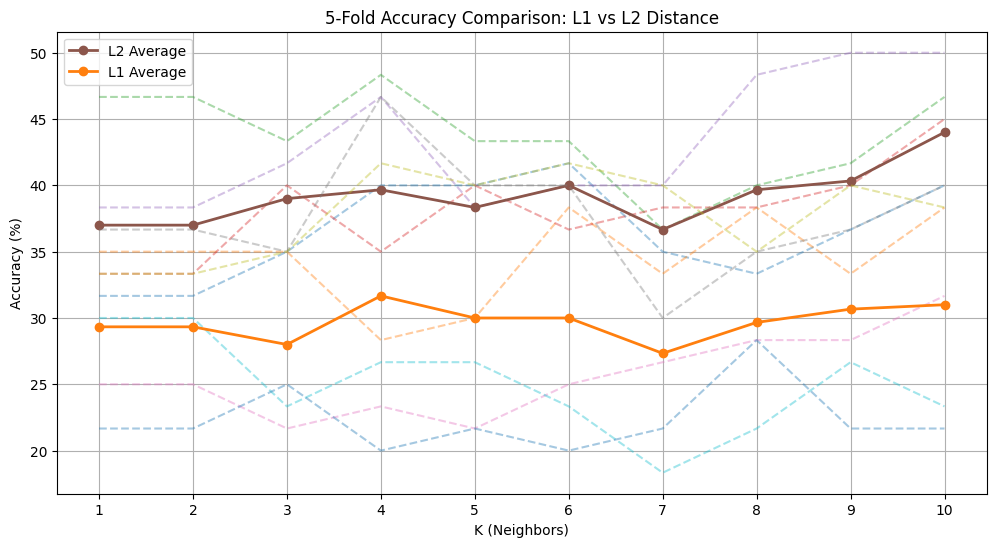

In [12]:
plt.figure(figsize=(12, 6))

for metric in metrics:
    for i in range(5):
        plt.plot(K_values, cv_results[metric][i], '--', alpha=0.4)

    avg = np.mean(cv_results[metric], axis=0)
    plt.plot(K_values, avg, marker='o', linewidth=2, label=f"{metric} Average")

plt.xlabel("K (Neighbors)")
plt.ylabel("Accuracy (%)")
plt.title("5-Fold Accuracy Comparison: L1 vs L2 Distance")
plt.xticks(K_values)
plt.grid(True)
plt.legend()
plt.show()


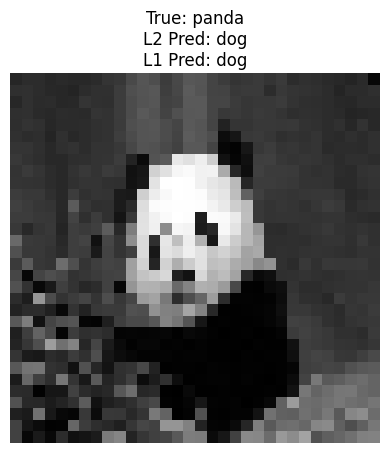

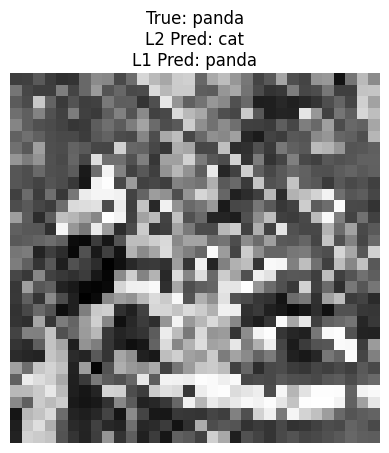

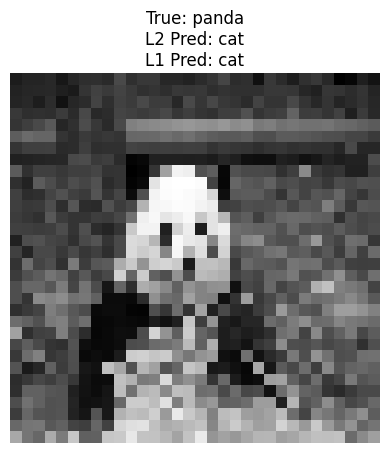

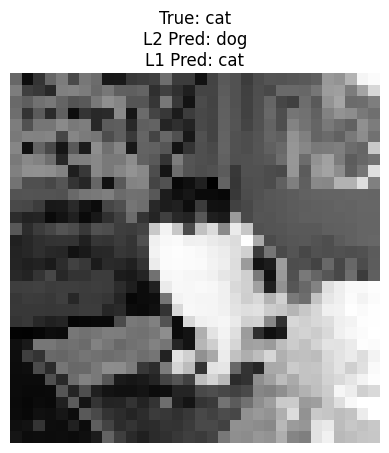

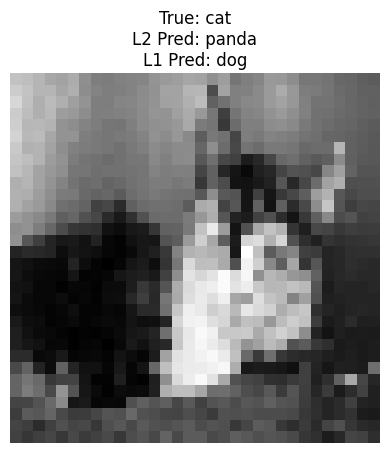

In [13]:
test_idx = np.random.choice(len(X_train), 5, replace=False)
X_test = X_train[test_idx]
y_test = y_train[test_idx]

for i in range(5):
    pred_L2 = knn_predict(X_train, y_train, X_test[i], k=5, metric='L2')
    pred_L1 = knn_predict(X_train, y_train, X_test[i], k=5, metric='L1')

    plt.imshow(X_test[i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    plt.title(f"True: {categories[y_test[i]]}\nL2 Pred: {categories[pred_L2]}\nL1 Pred: {categories[pred_L1]}")
    plt.axis('off')
    plt.show()